<a href="https://colab.research.google.com/github/rafaelmgr12/ds-projects/blob/main/Predict-Future-Sales/Predict_futures_sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict Future Sales
Final project for "How to win a data science competition" Coursera course

## Data Description
You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

File descriptions

* sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
* test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
* sample_submission.csv - a sample submission file in the correct format.
* items.csv - supplemental information about the items/products.
* item_categories.csv  - supplemental information about the items categories.
* shops.csv- supplemental information about the shops.

Data fields

* ID - an Id that represents a (Shop, Item) tuple within the test set
* shop_id - unique identifier of a shop
* item_id - unique identifier of a product
* item_category_id - unique identifier of item category
* item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
* item_price - current price of an item
* date - date in format dd/mm/yyyy
* date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
* item_name - name of item
* shop_name - name of shop
* item_category_name - name of item category

This dataset is permitted to be used for any purpose, including commercial use.

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
  from google.colab import files
  files.upload()
  ! mkdir ~/.kaggle
  ! wget --quiet https://raw.githubusercontent.com/rafaelmgr12/ds-projects/main/functions/ml_functions.py -O ml_functions.py
  ! wget --quiet https://raw.githubusercontent.com/rafaelmgr12/ds-projects/main/functions/plots_functions.py -O plot_functions.py
  ! pip install bayesian-optimization
  ! pip install sentencepiece
  ! pip install unidecode
  ! pip install category-encoders
  ! cp kaggle.json ~/.kaggle/
  ! chmod 600 ~/.kaggle/kaggle.json
  ! kaggle competitions download -c competitive-data-science-predict-future-sales
  ! unzip items.csv.zip && unzip sales_train.csv.zip && unzip sample_submission.csv.zip && unzip test.csv.zip 

Saving kaggle.json to kaggle.json
  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=957458e419748a901a650e04fa8c9a84646f308f5190cff9bfe7ed249e336049
  Stored in directory: /root/.cache/pip/wheels/fd/9b/71/f127d694e02eb40bcf18c7ae9613b88a6be4470f57a8528c5b
Successfully built bayesian-optimization
     |████████████████████████████████| 1.2 MB 10.4 MB/s 
     |████████████████████████████████| 241 kB 10.2 MB/s 
     |████████████████████████████████| 80 kB 3.8 MB/s 
  0% 0.00/2.91k [00:00<?, ?B/s]
100% 2.91k/2.91k [00:00<00:00, 5.65MB/s]
  0% 0.00/3.49k [00:00<?, ?B/s]
100% 3.49k/3.49k [00:00<00:00, 3.30MB/s]
  0% 0.00/1.02M [00:00<?, ?B/s]
100% 1.02M/1.02M [00:00<00:00, 68.4MB/s]
  0% 0.00/468k [00:00<?, ?B/s]
100% 468k/468k [00:00<00:00, 130MB/s]
  0% 0.00/368k [00:00<?, ?B/s]
100% 368k/368k [00:00<00:00, 118MB/s]
 68% 9.00M/13.3M [00:00<00:00, 34.9MB/s]
100% 13.3M/13.3M [00:00<00:00, 44.0MB/s]
Archive:  items.csv.zip
  i

In [2]:
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor

import time
import sys
import gc
import pickle
sys.version_info
# data
from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# load data
items = pd.read_csv('/content/items.csv')
shops = pd.read_csv('/content/shops.csv')
cats = pd.read_csv('/content/item_categories.csv')
train = pd.read_csv('/content/sales_train.csv')
# set index to ID to avoid droping it later
test  = pd.read_csv('/content/test.csv').set_index('ID')

In [4]:
train.head()


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
print('train size, item in train, shop in train', train.shape[0], train.item_id.nunique(), train.shop_id.nunique())
print('train size, item in train, shop in train', test.shape[0], test.item_id.nunique(),test.shop_id.nunique())
print('new items:', len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id)))), len(list(set(test.item_id))), len(test))

train size, item in train, shop in train 2935849 21807 60
train size, item in train, shop in train 214200 5100 42
new items: 363 5100 214200


In [6]:
train.isnull().sum()


date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

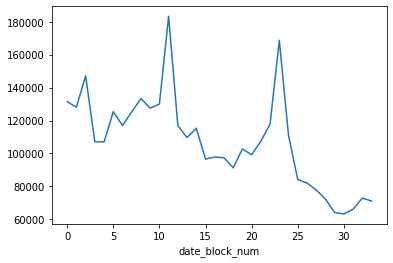

In [7]:
sale_by_month = train.groupby('date_block_num')['item_cnt_day'].sum()
sale_by_month.plot()

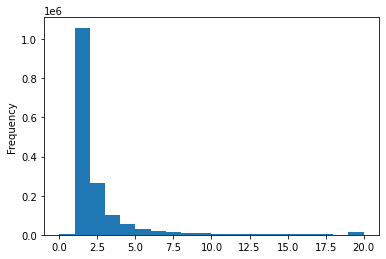

In [8]:

block_item_shop_sale = train.groupby(['date_block_num','item_id','shop_id'])['item_cnt_day'].sum()
block_item_shop_sale.clip(0,20).plot.hist(bins=20)

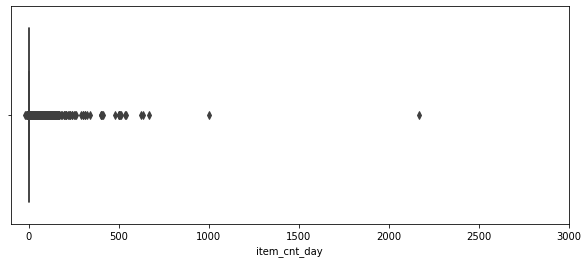

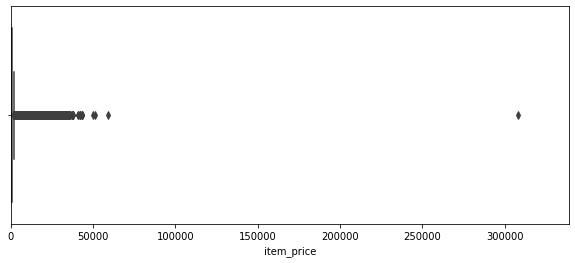

In [9]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]

In [10]:
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median

In [11]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [12]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
# if subtype is nan then type
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]

items.drop(['item_name'], axis=1, inplace=True)

In [13]:
ts = time.time()
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)
time.time() - ts

17.83748197555542

In [14]:
train['revenue'] = train['item_price'] *  train['item_cnt_day']


In [15]:

ts = time.time()
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float32))
time.time() - ts

4.943169832229614

In [16]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

In [17]:
ts = time.time()
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month
time.time() - ts

0.06849288940429688

In [18]:
ts = time.time()
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)
time.time() - ts

3.995361089706421

In [19]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [20]:
ts = time.time()
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')
time.time() - ts


32.99597764015198

In [21]:
def add_group_stats(matrix_, groupby_feats, target, enc_feat, last_periods):
    if not 'date_block_num' in groupby_feats:
        print ('date_block_num must in groupby_feats')
        return matrix_
    
    group = matrix_.groupby(groupby_feats)[target].sum().reset_index()
    max_lags = np.max(last_periods)
    for i in range(1,max_lags+1):
        shifted = group[groupby_feats+[target]].copy(deep=True)
        shifted['date_block_num'] += i
        shifted.rename({target:target+'_lag_'+str(i)},axis=1,inplace=True)
        group = group.merge(shifted, on=groupby_feats, how='left')
    group.fillna(0,inplace=True)
    for period in last_periods:
        lag_feats = [target+'_lag_'+str(lag) for lag in np.arange(1,period+1)]
        # we do not use mean and svd directly because we want to include months with sales = 0
        mean = group[lag_feats].sum(axis=1)/float(period)
        mean2 = (group[lag_feats]**2).sum(axis=1)/float(period)
        group[enc_feat+'_avg_sale_last_'+str(period)] = mean
        group[enc_feat+'_std_sale_last_'+str(period)] = (mean2 - mean**2).apply(np.sqrt)
        group[enc_feat+'_std_sale_last_'+str(period)].replace(np.inf,0,inplace=True)
        # divide by mean, this scales the features for NN
        group[enc_feat+'_avg_sale_last_'+str(period)] /= group[enc_feat+'_avg_sale_last_'+str(period)].mean()
        group[enc_feat+'_std_sale_last_'+str(period)] /= group[enc_feat+'_std_sale_last_'+str(period)].mean()
    cols = groupby_feats + [f_ for f_ in group.columns.values if f_.find('_sale_last_')>=0]
    matrix = matrix_.merge(group[cols], on=groupby_feats, how='left')
    return matrix

In [22]:
ts = time.time()
matrix = add_group_stats(matrix, ['date_block_num', 'item_id'], 'item_cnt_month', 'item', [6,12])
matrix = add_group_stats(matrix, ['date_block_num', 'shop_id'], 'item_cnt_month', 'shop', [6,12])
matrix = add_group_stats(matrix, ['date_block_num', 'item_category_id'], 'item_cnt_month', 'category', [12])
matrix = add_group_stats(matrix, ['date_block_num', 'city_code'], 'item_cnt_month', 'city', [12])
matrix = add_group_stats(matrix, ['date_block_num', 'type_code'], 'item_cnt_month', 'type', [12])
matrix = add_group_stats(matrix, ['date_block_num', 'subtype_code'], 'item_cnt_month', 'subtype', [12])
time.time() - ts

16.734712839126587

In [23]:
#first use target encoding each group, then shift month to creat lag features
def target_encoding(matrix_, groupby_feats, target, enc_feat, lags):
    print ('target encoding for',groupby_feats)
    group = matrix_.groupby(groupby_feats).agg({target:'mean'})
    group.columns = [enc_feat]
    group.reset_index(inplace=True)
    matrix = matrix_.merge(group, on=groupby_feats, how='left')
    matrix[enc_feat] = matrix[enc_feat].astype(np.float16)
    matrix = lag_feature(matrix, lags, enc_feat)
    matrix.drop(enc_feat, axis=1, inplace=True)
    return matrix

In [24]:
ts = time.time()
matrix = target_encoding(matrix, ['date_block_num'], 'item_cnt_month', 'date_avg_item_cnt', [1])
matrix = target_encoding(matrix, ['date_block_num', 'item_id'], 'item_cnt_month', 'date_item_avg_item_cnt', [1,2,3,6,12])
matrix = target_encoding(matrix, ['date_block_num', 'shop_id'], 'item_cnt_month', 'date_shop_avg_item_cnt', [1,2,3,6,12])
matrix = target_encoding(matrix, ['date_block_num', 'item_category_id'], 'item_cnt_month', 'date_cat_avg_item_cnt', [1])
matrix = target_encoding(matrix, ['date_block_num', 'shop_id', 'item_category_id'], 'item_cnt_month', 'date_shop_cat_avg_item_cnt', [1])
matrix = target_encoding(matrix, ['date_block_num', 'city_code'], 'item_cnt_month', 'date_city_avg_item_cnt', [1])
matrix = target_encoding(matrix, ['date_block_num', 'item_id', 'city_code'], 'item_cnt_month', 'date_item_city_avg_item_cnt', [1])
time.time() - ts

target encoding for ['date_block_num']
target encoding for ['date_block_num', 'item_id']
target encoding for ['date_block_num', 'shop_id']
target encoding for ['date_block_num', 'item_category_id']
target encoding for ['date_block_num', 'shop_id', 'item_category_id']
target encoding for ['date_block_num', 'city_code']
target encoding for ['date_block_num', 'item_id', 'city_code']


168.4471468925476

In [25]:
ts = time.time()
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

# https://stackoverflow.com/questions/31828240/first-non-null-value-per-row-from-a-list-of-pandas-columns/31828559
# matrix['price_trend'] = matrix[['delta_price_lag_1','delta_price_lag_2','delta_price_lag_3']].bfill(axis=1).iloc[:, 0]
# Invalid dtype for backfill_2d [float16]

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

time.time() - ts

233.87961411476135

In [26]:
ts = time.time()
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'delta_revenue')

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)
time.time() - ts

24.31271529197693

In [27]:
matrix['month'] = matrix['date_block_num'] % 12
matrix['year'] = (matrix['date_block_num'] / 12).astype(np.int8)

In [28]:
#Month since last sale for each shop/item pair.
ts = time.time()
last_sale = pd.DataFrame()
for month in range(1,35):    
    last_month = matrix.loc[(matrix['date_block_num']<month)&(matrix['item_cnt_month']>0)].groupby(['item_id','shop_id'])['date_block_num'].max()
    df = pd.DataFrame({'date_block_num':np.ones([last_month.shape[0],])*month,
                       'item_id': last_month.index.get_level_values(0).values,
                       'shop_id': last_month.index.get_level_values(1).values,
                       'item_shop_last_sale': last_month.values})
    last_sale = last_sale.append(df)
last_sale['date_block_num'] = last_sale['date_block_num'].astype(np.int8)

matrix = matrix.merge(last_sale, on=['date_block_num','item_id','shop_id'], how='left')
time.time() - ts

27.838441371917725

In [29]:
#Month since last sale for each item.
ts = time.time()
last_sale = pd.DataFrame()
for month in range(1,35):    
    last_month = matrix.loc[(matrix['date_block_num']<month)&(matrix['item_cnt_month']>0)].groupby('item_id')['date_block_num'].max()
    df = pd.DataFrame({'date_block_num':np.ones([last_month.shape[0],])*month,
                       'item_id': last_month.index.values,
                       'item_last_sale': last_month.values})
    last_sale = last_sale.append(df)
last_sale['date_block_num'] = last_sale['date_block_num'].astype(np.int8)

matrix = matrix.merge(last_sale, on=['date_block_num','item_id'], how='left')
time.time() - ts

18.268021821975708

In [30]:
# Months since the first sale for each shop/item pair and for item only.
ts = time.time()
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')
time.time() - ts

1.9982175827026367

In [31]:
matrix = matrix[matrix.date_block_num > 11]
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'city_code',
       'item_category_id', 'type_code', 'subtype_code', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6',
       'item_cnt_month_lag_12', 'item_avg_sale_last_6', 'item_std_sale_last_6',
       'item_avg_sale_last_12', 'item_std_sale_last_12',
       'shop_avg_sale_last_6', 'shop_std_sale_last_6', 'shop_avg_sale_last_12',
       'shop_std_sale_last_12', 'category_avg_sale_last_12',
       'category_std_sale_last_12', 'city_avg_sale_last_12',
       'city_std_sale_last_12', 'type_avg_sale_last_12',
       'type_std_sale_last_12', 'subtype_avg_sale_last_12',
       'subtype_std_sale_last_12', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
       'date_item_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_

In [33]:
matrix.to_pickle('/content/data.pkl')
del matrix
del group
del items
del shops
del cats
del train
# leave test for submission
gc.collect();

## Model Training

**LGBM**

In [35]:
data = pd.read_pickle('/content/data.pkl')
data = data[[
    'date_block_num',
    'shop_id',
    #'item_id',
    'item_cnt_month',
    'city_code',
    'item_category_id',
    'type_code','subtype_code',
    'item_cnt_month_lag_1','item_cnt_month_lag_2','item_cnt_month_lag_3','item_cnt_month_lag_6','item_cnt_month_lag_12',
    'item_avg_sale_last_6', 'item_std_sale_last_6',
    'item_avg_sale_last_12', 'item_std_sale_last_12',
    'shop_avg_sale_last_6', 'shop_std_sale_last_6',
    'shop_avg_sale_last_12', 'shop_std_sale_last_12',
    'category_avg_sale_last_12', 'category_std_sale_last_12',
    'city_avg_sale_last_12', 'city_std_sale_last_12',
    'type_avg_sale_last_12', 'type_std_sale_last_12',
    'subtype_avg_sale_last_12', 'subtype_std_sale_last_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1','date_item_avg_item_cnt_lag_2','date_item_avg_item_cnt_lag_3','date_item_avg_item_cnt_lag_6','date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1','date_shop_avg_item_cnt_lag_2','date_shop_avg_item_cnt_lag_3','date_shop_avg_item_cnt_lag_6','date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month','year',
    'item_shop_last_sale','item_last_sale',
    'item_shop_first_sale','item_first_sale',
]]

cat_feats = ['shop_id','city_code','item_category_id','type_code','subtype_code']

In [36]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

del data
gc.collect();

In [37]:
model = LGBMRegressor(
    max_depth = 8,
    n_estimators = 500,
    colsample_bytree=0.7,
    min_child_weight = 300,
    reg_alpha = 0.1,
    reg_lambda = 1,
    random_state = 42,
)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=10, 
    early_stopping_rounds = 40,
    categorical_feature = cat_feats) # use LGBM's build-in categroical features.


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['city_code', 'item_category_id', 'shop_id', 'subtype_code', 'type_code']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 40 rounds.
[10]	training's rmse: 0.914915	training's l2: 0.837069	valid_1's rmse: 0.938257	valid_1's l2: 0.880326
[20]	training's rmse: 0.854046	training's l2: 0.729395	valid_1's rmse: 0.900808	valid_1's l2: 0.811455
[30]	training's rmse: 0.833372	training's l2: 0.694509	valid_1's rmse: 0.893426	valid_1's l2: 0.79821
[40]	training's rmse: 0.823877	training's l2: 0.678774	valid_1's rmse: 0.891299	valid_1's l2: 0.794414
[50]	training's rmse: 0.817065	training's l2: 0.667596	valid_1's rmse: 0.891912	valid_1's l2: 0.795507
[60]	training's rmse: 0.81235	training's l2: 0.659913	valid_1's rmse: 0.890982	valid_1's l2: 0.79385
[70]	training's rmse: 0.808223	training's l2: 0.653224	valid_1's rmse: 0.892136	valid_1's l2: 0.795906
[80]	training's rmse: 0.804514	training's l2: 0.647243	valid_1's rmse: 0.892472	valid_1's l2: 0.796506
[90]	training's rmse: 0.80169	training's l2: 0.642707	valid_1's rmse: 0.892535	valid_1's l2: 0.796619
[100]	training'

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.7,
              importance_type='split', learning_rate=0.1, max_depth=8,
              min_child_samples=20, min_child_weight=300, min_split_gain=0.0,
              n_estimators=500, n_jobs=-1, num_leaves=31, objective=None,
              random_state=42, reg_alpha=0.1, reg_lambda=1, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [39]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

X_train_level2 = pd.DataFrame({
    "ID": np.arange(Y_pred.shape[0]), 
    "item_cnt_month": Y_pred
})
X_train_level2.to_csv('/content/lgb_valid.csv', index=False)

submission = pd.DataFrame({
    "ID": np.arange(Y_test.shape[0]), 
    "item_cnt_month": Y_test
})
submission.to_csv('/content/submission.csv', index=False)

In [40]:
! kaggle competitions submit -c competitive-data-science-predict-future-sales -f submission.csv -m "LGBM test"

100% 5.26M/5.26M [00:04<00:00, 1.19MB/s]
Successfully submitted to Predict Future Sales